In this notebook, we will try a new idea for image compression applying to the MNIST dataset. Since the MMD method used the results of the KMeans Clustering and this methods does not work well, we will try to improve the quality of the clusters then the compression rate.


The main idea that we want to expriment here is that, since we already have the labels, there is no need to fit a clustering algorithme to the whole dataset. However, we will apply a clustering algorithm to each subset corresponding to each class of the dataset.

Another remark is that, the MMD method (and all other set redundancy method) will produce a (some) new image(s) for each set, that why sometimes we can't reduce the size of the compressed images. So we will not create a new image but use an element of the image set as the reference and try to reduce the information of all other images in that set with respect to the reference.

Also, the hypothesis that all images are similar in the same set is quite restricted in real life data. So, an idea to deal with this issue is that we can reduce the number of images in each set. And in each set, we just compresse the set without producing some new images, we hope that this can reduce dramatically the size.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

## Data Loading

In [2]:
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

# Transformation applied on each image
transform = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor()])

train_dataset = MNIST(root='./MNIST', train=True, transform = None, download=True)

c:\Users\nguye\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


The MNIST dataset has 10 classes

In [3]:
n_classes = 10
n_images = 60000

We store the images and its labels 

In [4]:
X = []
labels = []
for k in range(60000):
    X.append(np.array(train_dataset[k][0]))
    labels.append(np.array(train_dataset[k][1]))
X = np.array(X)
labels = np.array(labels)

## Visualization of images in the same class

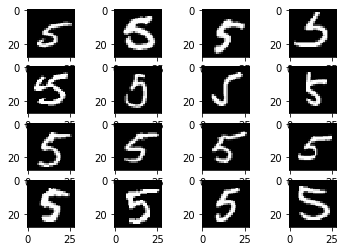

In [6]:
fig, axs = plt.subplots(4,4)
axs = axs.ravel()
idx = np.random.choice(np.where(labels == 5)[0], size = 16)

for k in range(len(axs)):
    axs[k].imshow(X[idx[k]], cmap = 'gray')

## Apply to the whole dataset

We will calculate the distances for all images in the whole dataset, and we will divide them into several subset in which the distance is minimal.

In [5]:
from sklearn.neighbors import NearestNeighbors

In [6]:
X_fatten = X.reshape((n_images, -1))

### With 2 images in each set

In [7]:
NN = NearestNeighbors(n_jobs = -1, p = 1)
NN.fit(X_fatten)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=-1, n_neighbors=5, p=1, radius=1.0)

Define image sets index:      

An array of shape (n_images / n_neighbors, n_neighbors), each row contains the indexes of images in each image set

In [61]:
NN.kneighbors(X_fatten[10:11,], n_neighbors = 2, return_distance = False)

array([[    0, 32248]], dtype=int64)

In [63]:
NN_X_2.kneighbors(X_fatten[32248:32249,],  n_neighbors = 2, return_distance = False)

array([[32248, 46358]], dtype=int64)

In [ ]:
NN_X_2.kneighbors(X_fatten[32248:32249,],  n_neighbors = 2, return_distance = False)

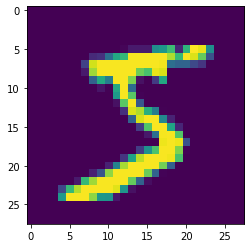

In [65]:
plt.imshow(X[0])

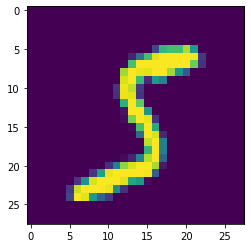

In [66]:
plt.imshow(X[32248])

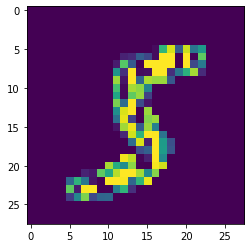

In [69]:
plt.imshow(np.abs(X[46358] - X[32248]))

In [51]:
cv2.imwrite("org.png", X[0])
cv2.imwrite("diff.png", np.abs(X[0] - X[32248]))


True

In [32]:
np.save("org.npy", X[32248])
np.save("diff.npy", X[32248] - X[0]) 

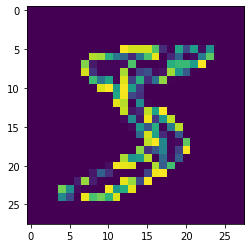

In [52]:
plt.imshow(np.abs(X[32248] - X[0]))

### Combine with Delta Encoder

In [47]:
def Delta_Encoder_Single(X):
    '''
    Delta encoder
    '''
    Y = np.copy(X)
    Y[1:,:] = X[1:,:] - X[:-1,:]

    return Y 

In [35]:
def Delta_Encoder(X):
    '''
    Delta encoder
    '''
    Y = np.copy(X)
    Y[:,1:,:] = X[:,1:,:] - X[:,:-1,:]

    return Y 

In [36]:
X_delta = Delta_Encoder(X)


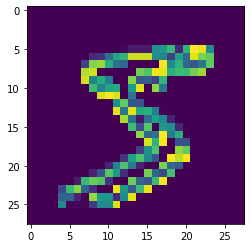

In [37]:
plt.imshow(X_delta[0])

In [39]:
X_delta_flatten = X_delta.reshape((n_images, -1))

In [40]:
NN_X_delta_2 = NearestNeighbors(n_neighbors = 2, n_jobs = -1)
NN_X_delta_2.fit(X_delta_flatten)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=-1, n_neighbors=2, p=2, radius=1.0)

In [42]:
NN_X_delta_2.kneighbors(X_delta_flatten[0:1], n_neighbors = 2, return_distance= False)

array([[    0, 52057]], dtype=int64)

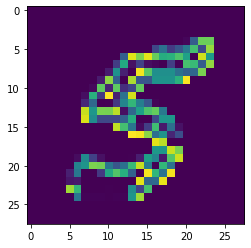

In [43]:
plt.imshow(X_delta[52057])

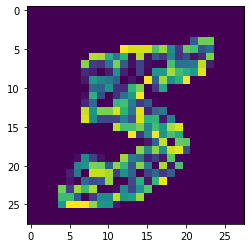

In [44]:
plt.imshow(X_delta[52057] -  X_delta[0])

In [45]:
cv2.imwrite("org.png", X_delta[52057])
cv2.imwrite("diff.png", X_delta[52057] - X_delta[0])


True